In [1]:
import pystare
import pystareplotlib
import pystareplotlib.pystareplotlib as psplot
from pystareplotlib.pystareplotlib import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.geodesic import Geodesic

import numpy
import math
from math import sqrt,sin,cos

import pyproj
import scipy.linalg
from scipy.linalg import expm, norm

In [2]:
# Define Global Constants and State Variables
# -------------------------------------------

# Set up the projection and transformation
# PROJ = ccrs.PlateCarree()
# PROJ = ccrs.Robinson()
PROJ = ccrs.Mollweide()
TRANSF = ccrs.Geodetic()
USR_SET_GLOBAL = True

# Plot options
usr_plot_options = {'projection': PROJ, 'transform': TRANSF}
DEFAULT_DPI = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5 * DEFAULT_DPI
mpl.rcParams['legend.fontsize'] = 6

In [3]:
nearside_plot_options = {
    'projection':
    ccrs.NearsidePerspective(central_longitude=0.0
                             ,central_latitude=45.0
                             ,satellite_height=35785831
                             ,false_easting=0
                             ,false_northing=0
                             ,globe=None)
    ,'transform': ccrs.Geodetic()
}
    

In [4]:
nearside_plot_options['projection'].threshold

219053.44391861386

In [5]:
pystare.__version__

'0.8.3'

In [6]:
sivs = make_stare_htm_info_from_sivs(make_all_stare_htm_at_level().htm.data)

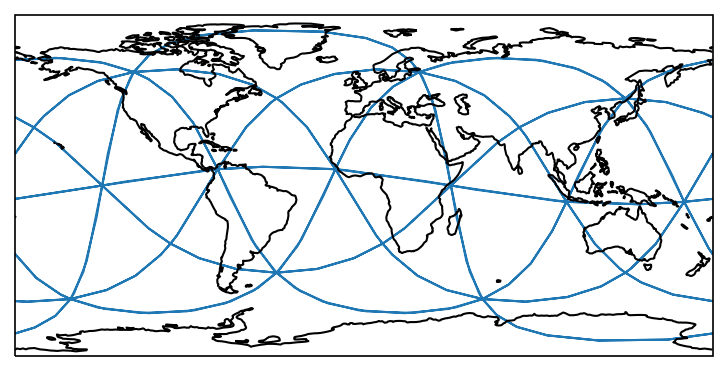

/Users/mrilee/opt/anaconda3/envs/stare/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/mrilee/opt/anaconda3/envs/stare/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/var/folders/q9/t6pps0j954l457p2dlg95bw00000gn/T/ipykernel_9929/1684774404.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#de

/var/folders/q9/t6pps0j954l457p2dlg95bw00000gn/T/ipykernel_9929/831470559.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ,face_zs=numpy.ones(shape=[3*len(pp_covers[i][i0:i1])],dtype=numpy.float)*0.5
/var/folders/q9/t6pps0j954l457p2dlg95bw00000gn/T/ipykernel_9929/1684774404.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ,face_z

In [7]:
figax,sivs_cache,sivs_triang = hello_plot(
    spatial_index_values=sivs
    ,set_coastlines=True
#    ,plot_options=nearside_plot_options
    ,set_global=False
    ,show_fig=False)

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.
del figax

In [8]:
crs_geocentric = ccrs.Geocentric()
crs_geodetic   = ccrs.Geodetic()

In [9]:
x=numpy.array([6378137,0,0],dtype=numpy.double)
y=numpy.array([0,6378137,0],dtype=numpy.double)
z=numpy.array([0,0,6.35675231e+06],dtype=numpy.double)
# z = None
crs_geodetic.transform_points(crs_geocentric,x,y,z)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.00000000e+01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.00000000e+01, -4.24517971e-03]])

In [10]:
def RN(phi,lam):
    a=6378137.0; c=6356752.314245; fi=298.257223563
    return a/sqrt(1-((sin(phi)**2) * (a*a-c*c))/(a*a)),a,c

In [11]:
def xyz(phi,lam,h):
    rn,a,c=RN(phi,lam)
    return (rn+h)*cos(phi)*cos(lam),\
           (rn+h)*cos(phi)*sin(lam),\
           (rn*c*c/(a*a)+h)*sin(phi)
                        

In [12]:
xyz(0,0,1)

(6378138.0, 0.0, 0.0)

In [13]:
def phi_lam_h(x,y,z):
    w = sqrt(x*x + y*y)
    

In [14]:
type(tri)

module

In [15]:
type(mpl.tri)

module

In [16]:

xyz_to_lonlatalt= pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
    )

lonlatalt_to_xyz = pyproj.Transformer.from_crs(
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    )


In [17]:

x = -652954.1006
y = 4774619.7919
z = -2217647.7937
lon1, lat1, alt1 = xyz_to_lonlatalt.transform(x,y,z,radians=False)
print (lat1, lon1, alt1 )


lon1=0
lat1=0
alt1=0
x,y,z = lonlatalt_to_xyz.transform(lon1,lat1,alt1,radians=False)
print(x,y,z)

-24.887220848803032 97.78719043261641 -1069542.1692923503
6378137.0 0.0 0.0


In [18]:
xyz_to_lonlatalt.transform(1,0,0,radians=False)

(0.0, 90.0, -6356752.314245179)

In [19]:
lonlatalt_to_xyz.transform(0.0, 90.0, 0)

(3.9186209248144716e-10, 0.0, 6356752.314245179)

In [20]:
def to_xyz(lla):
    return lonlatalt_to_xyz.transform(lla[0],lla[1],lla[2],radians=False)
def to_lla(xyz):
    return xyz_to_lonlatalt.transform(xyz[0],xyz[1],xyz[2],radians=False)

In [21]:
# def norm(x):
#     return x/numpy.sqrt((x*x).sum())

def tri(center_lon,center_lat,delta_lon,delta_lat):
    x = numpy.array(lonlatalt_to_xyz.transform(center_lon,center_lat,0),dtype=numpy.double)
    p = numpy.array(lonlatalt_to_xyz.transform(center_lon+delta_lon,center_lat+delta_lat,0),dtype=numpy.double)
    n = numpy.cross(x,p); n = n/norm(n)
    return x,p,n

def rot(a,n,theta):
    M = expm(numpy.cross(numpy.eye(3),n*(theta*numpy.pi/180.0)))
    return numpy.dot(M,a)

def rotM(a,M):
    return numpy.dot(M,a)

def make_rot_matrix(n,theta):
    return expm(numpy.cross(numpy.eye(3),n*(theta*numpy.pi/180.0)))

def patch(x,n,along,across):
    xp = rot(x,n,along/2.0)
    xm = rot(x,n,-along/2.0)
    
    np  = numpy.cross(n,xp); np = np/norm(np)
    xpp = rot(xp,np,across/2.0)
    xpm = rot(xp,np,-across/2.0)
    
    nm  = numpy.cross(n,xm); nm = nm/norm(nm)
    xmp = rot(xm,nm,across/2.0)
    xmm = rot(xm,nm,-across/2.0)
    
    return [xmp,xpp,xpm,xmm]

def make_periodic(a):
    return a+a[0:1]

def patch_geodetic(p):
    return zip(*map(to_lla,p))

def patch_periodic(p):
    return map(make_periodic,patch_geodetic(p))

def make_swath(center_lon=0,center_lat=0,along=10,across=10,delta_deg=10,delta_lon=0.0,delta_lat=1.0
               ,cover_res=4
                ):
    t__ = tri(center_lon,center_lat,delta_lon,delta_lat)
    n  = t__[2]
    c0 = t__[0]
    centers      = [ rot(c0,n,i) for i in range(0,361,delta_deg) ]
    centers_llas = [ to_lla(c) for c in centers ]
    centers_lons,centers_lats,alts = zip(*centers_llas)
    patches      = [ patch(c,n,delta_deg,delta_deg) for c in centers ]
    pp_lons = []
    pp_lats = []
    pp_covers = []
    for p in patches:
        pp = list(patch_periodic(p))
        pp_lons.append(pp[0]); pp_lats.append(pp[1])
        pp_covers.append(pystare.cover_from_hull(pp[1],pp[0],cover_res))
        
    return centers_lons,centers_lats,pp_lons,pp_lats,pp_covers

In [22]:
centers_lons,centers_lats,pp_lons,pp_lats,pp_covers = make_swath(center_lat=60,delta_lon=1,delta_lat=2.0,delta_deg=20)
centers_lons1,centers_lats1,pp_lons1,pp_lats1,pp_covers1 = make_swath(center_lat=25,delta_lon=0.9,delta_lat=0.1,delta_deg=20)

In [23]:
sivs0 = make_stare_htm_info_from_sivs(make_all_stare_htm_at_level(level=0).htm.data)
sivs = make_stare_htm_info_from_sivs(make_all_stare_htm_at_level(level=4).htm.data)

In [24]:
# threshold_save = nearside_plot_options['projection'].threshold
# threshold_save # 219053.44391861386

In [25]:
nearside_plot_options['projection']._threshold = 10000.0

In [26]:
plot_options = nearside_plot_options
# plot_options = None

In [27]:
cd_cmap=plt.cm.get_cmap('rainbow')

face_zs             [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
face_zs len         84
siv_triang tri len  (28, 3)
face_edgecolors  None
face_lw          0.5
face_shading     gouraud
face_vmin        0
face_vmax        1
face_cmap        <matplotlib.colors.LinearSegmentedColormap object at 0x12cd09fd0>
face_alpha       1
po transform     <cartopy._crs.Geodetic object at 0x137a7a0e0>
rasterized       True


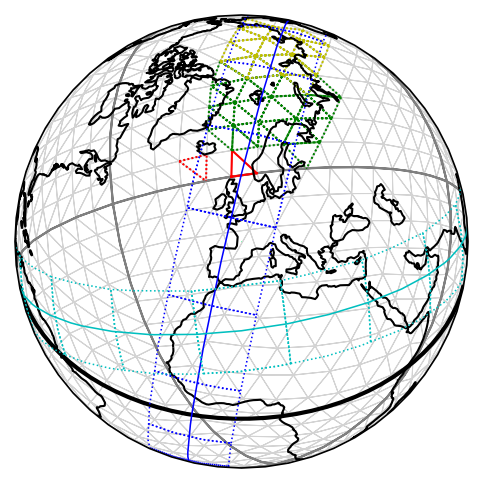

In [28]:
figax,sivs_cache,sivs_triang = hello_plot(
    spatial_index_values=sivs
    ,set_coastlines=True
    ,plot_options=plot_options
    ,set_global=True
    ,show_fig=False
    ,lw=0.5
    ,color='lightgrey')

if True:
    figax,sivs_cache,sivs_triang = hello_plot(
        figax=figax
        ,spatial_index_values=sivs0
        ,set_coastlines=True
        ,plot_options=plot_options
        ,set_global=True
        ,show_fig=False
        ,color='grey')

# i=0
# di=1024
# sivs.htm[i:i+di]
if True:
    figax,sivs_cache,sivs_triang = hello_plot(
        figax=figax
        ,spatial_index_values=pystare.from_latlon([60],[0],4)
        ,set_coastlines=True
        ,plot_options=plot_options
        ,set_global=True
        ,show_fig=False
        ,color='r')

    figax,sivs_cache,sivs_triang = hello_plot(
        figax=figax
        ,spatial_index_values=pystare.from_latlon([60],[-20],4)
        ,set_coastlines=True
        ,plot_options=plot_options
        ,set_global=True
        ,show_fig=False
        ,color='r'
        ,use_dash=[1])

    figax.ax.plot(centers_lons,centers_lats,transform=ccrs.Geodetic()
                  ,color='b'
                  ,lw=0.75)

    for i in range(len(pp_lons)):
        figax.ax.plot(pp_lons[i],pp_lats[i],transform=ccrs.Geodetic(),color='b'
                      ,linestyle=':'
                      ,lw=0.75)
    
    figax.ax.plot(centers_lons1,centers_lats1,transform=ccrs.Geodetic()
                  ,color='c'
                  ,lw=0.75)

    for i in range(len(pp_lons1)):
        figax.ax.plot(pp_lons1[i],pp_lats1[i],transform=ccrs.Geodetic(),color='c'
                      ,linestyle=':'
                      ,lw=0.75)
        
    i=1
    figax,sivs_cache,sivs_triang = hello_plot(
        figax=figax
        ,spatial_index_values=pp_covers[i]
        ,set_coastlines=True
        ,plot_options=plot_options
        ,set_global=True
        ,show_fig=False
        ,color='g'
        ,face_zs=numpy.ones(shape=[3*len(pp_covers[i])])*0.5
        ,face_alpha=1
        ,face_cmap=cd_cmap
        ,face_vmin=0
        ,face_vmax=1
        ,use_dash=[1]
        ,verbose=True
    )
    sivs_triang_1 = sivs_triang
    
    i=2
    figax,sivs_cache,sivs_triang = hello_plot(
        figax=figax
        ,spatial_index_values=pp_covers[i]
        ,set_coastlines=True
        ,plot_options=plot_options
        ,set_global=True
        ,show_fig=False
        ,color='y'
        ,face_alpha=0.7
        ,face_cmap=cd_cmap
        ,use_dash=[1])
    
gl = figax.ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='k', alpha=1, linestyle='-')

gl.ylocator = mticker.FixedLocator([0])
gl.xlines = False
gl.xlabels_top=False
gl.xlabels_left=False
gl.xlabels_bottom=False

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.
del figax

# Note root STARE index code... Probably 7...

In [29]:
print(
    len(sivs_triang_1.triangles)
    ,len(pp_covers[1])
    ,len(numpy.ones(shape=[len(pp_covers[1])]))
)

28 28 28


In [30]:
sivs_triang_1.triangles.shape

(28, 3)

In [31]:
sivs_triang_1.x.shape

(84,)

In [78]:
#del hello_plot1
def hello_plot1(spatial_index_values=None
               , figax=None, plot_options=None, set_global=None, set_coastlines=None
               , show_fig=None, color=None, lw=None, legend_label=None, use_dash=None
               , bbox_to_anchor=None
               , verbose=None
               , rasterized=None
               , face_zs         = None
#               , face_colors     = None
               , face_edgecolors = None
               , face_lw         = None
               , face_vmin       = None
               , face_vmax       = None
               , face_cmap       = None
               , face_shading    = None
               , face_alpha      = None
               , siv_triang      = None
              ):
    
    spatial_index_values = (None if spatial_index_values is None else spatial_index_values)
    figax = (None if figax is None else figax)
    plot_options = ({'projection': ccrs.PlateCarree()
                     , 'transform': ccrs.Geodetic()} if plot_options is None else plot_options)
    set_global = (False if set_global is None else set_global)
    set_coastlines = (True if set_coastlines is None else set_coastlines)
    show_fig = (True if show_fig is None else show_fig)
    color = (None if color is None else color)
    lw = (1 if lw is None else lw)
    legend_label = (None if legend_label is None else legend_label)
    use_dash = (None if use_dash is None else use_dash)
    bbox_to_anchor = (None if bbox_to_anchor is None else bbox_to_anchor)
    verbose = (True if verbose is None else verbose)
    rasterized = (True if rasterized is None else rasterized)

    face_zs         = None if face_zs is None else face_zs
#    face_colors     = None if face_colors is None else face_colors
    face_edgecolors = None if face_edgecolors is None else face_edgecolors
    face_lw         = 0.5 if face_lw is None else face_lw
    face_vmin       = None if face_vmin is None else face_vmin
    face_vmax       = None if face_vmax is None else face_vmax
    face_cmap       = None if face_cmap is None else face_cmap
    face_shading    = 'gouraud' if face_shading is None else face_shading
    face_alpha      = 0.75 if face_alpha is None else face_alpha

    siv_triang = None if siv_triang is None else siv_triang
    
    if figax is None:
        # Initialize the FigAxContainer the first time it is used
        figax = FigAxContainer(plt.subplots(1, subplot_kw=plot_options))
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()

    if spatial_index_values is not None:
        if not isinstance(spatial_index_values,xarray.Dataset):
            # Calculate vertices and interconnection matrix
            spatial_index_values = make_stare_htm_info_from_sivs(spatial_index_values)
            # lons, lats, intmat = pystare.triangulate_indices(spatial_index_values)

        lons = spatial_index_values.lons.data.reshape(3*len(spatial_index_values.htm))
        lats = spatial_index_values.lats.data.reshape(3*len(spatial_index_values.htm))
        intmat = spatial_index_values.intmat.data

        # Make triangulation object & plot
        if siv_triang is None:
            siv_triang = mpl.tri.Triangulation(lons, lats, intmat)

        divert_stderr()
        if use_dash is not None:
            figax.ax.triplot(siv_triang, c=color, transform=ccrs.Geodetic(), lw=lw,
                             label="Placeholder", dashes=use_dash, rasterized=rasterized)
#                        figax.ax.triplot(siv_triang, c=color, transform=plot_options['transform'], lw=lw,
#                             label="Placeholder", dashes=use_dash, rasterized=rasterized)  
        else:
            figax.ax.triplot(siv_triang, c=color, transform=ccrs.Geodetic(), lw=lw, 
                             label="Placeholder", rasterized=rasterized)
            
            
        if face_zs is not None:
            print('face_zs            ',face_zs)
            print('face_zs len        ',len(face_zs))
            print('siv_triang tri len ',siv_triang.triangles.shape)
#            print('face_colors     ',face_colors)
            print('face_edgecolors ',face_edgecolors)
            print('face_lw         ',face_lw)
            print('face_shading    ',face_shading)
            print('face_vmin       ',face_vmin)
            print('face_vmax       ',face_vmax)
            print('face_cmap       ',face_cmap)
            print('face_alpha      ',face_alpha)
            print('po transform    ',plot_options['transform'])
            print('rasterized      ',rasterized)
            print('siv_t type',type(siv_triang))
            print('siv_t x   ',siv_triang.x)
            print('siv_t tr  ',siv_triang.triangles)
            
#            figax.ax.tripcolor(siv_triang
#                               ,face_zs
##                               ,face_colors=face_colors
#                               ,edgecolors=face_edgecolors
#                               ,lw=face_lw
#                               ,shading=face_shading
#                               ,vmin=face_vmin
#                               ,vmax=face_vmax
#                               ,cmap=face_cmap
#                               ,alpha=face_alpha
##                               ,transform=plot_options['transform']
##                               ,transform=ccrs.PlateCarree()
#                               ,transform=ccrs.Geodetic()
#                               ,rasterized=rasterized
#                               ,antialiased=True
#                               )

            if face_cmap is not None:
                norm = mpl.colors.Normalize(vmin=face_vmin, vmax=face_vmax)
                m=cm.ScalarMappable(norm=norm,cmap=face_cmap)
                face_c=[mpl.colors.rgb2hex(m.to_rgba(z)) for z in face_zs]
            else:
                face_c=face_zs
            
#            face_c=['r','g']
#            face_c=['#00ffff','#ffff00']

            for i in range(len(siv_triang.triangles)):
                t = siv_triang.triangles[i]
            
                print('fill: ',i,t,siv_triang.x[t],siv_triang.y[t])
#                print('colo: ',face_zs[3*i:3*i+3],face_cmap(face_zs[3*i:3*i+3]))
#                print('colo: ',m.to_rgba(face_zs[3*i]))
                print('colo: ',face_c[i])
    
                figax.ax.fill(siv_triang.x[t]
                              ,siv_triang.y[t]
                              ,face_c[i]
                              ,transform=ccrs.Geodetic()
                              ,alpha=face_alpha
                              ,rasterized=rasterized
                             )

        restore_stderr(_verbose=verbose)
 
        # Add Legend
        if legend_label is not None:
            if isinstance(legend_label, list):
                # plt.triplot produces two legend entries. 
                #  The first of those are the edges
                #  The second contains the points (nodes).
                bbox_to_anchor = ( (1.7,1.0) if bbox_to_anchor is None else bbox_to_anchor )
                the_handels, the_labels = figax.ax.get_legend_handles_labels()
                figax.ax.legend(handles=the_handels[::2], labels=legend_label, bbox_to_anchor=bbox_to_anchor
                                , loc='upper right', frameon=False) 
            elif isinstance(legend_label, str):
                bbox_to_anchor = ( (1.4,1.0) if bbox_to_anchor is None else bbox_to_anchor )
                h, l = figax.ax.get_legend_handles_labels()
                figax.ax.legend(handles=[h[0]], labels=[legend_label], bbox_to_anchor=bbox_to_anchor
                                , loc='upper right', frameon=False)

    if show_fig:
        # Show figure now
        plt.show()

    return figax,spatial_index_values,siv_triang

In [ ]:
sivs_triang.x

In [ ]:
plot_options

In [ ]:
plot_options = {
    'projection':
    ccrs.NearsidePerspective(central_longitude=0.0
                             ,central_latitude=45.0
                             ,satellite_height=35785831
                             ,false_easting=0
                             ,false_northing=0
                             ,globe=None)
    ,'transform': ccrs.Geodetic()
}
    

In [ ]:
usr_plot_options    

face_zs             ['y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y']
face_zs len         28
siv_triang tri len  (28, 3)
face_edgecolors  k
face_lw          0.0
face_shading     gouraud
face_vmin        0.0
face_vmax        1.0
face_cmap        None
face_alpha       0.5
po transform     <cartopy._crs.Geodetic object at 0x137a7a0e0>
rasterized       True
siv_t type <class 'matplotlib.tri.triangulation.Triangulation'>
siv_t x    [  12.74409415    8.99832043   22.7923471   -45.          -29.28315926
   -7.09784647  -21.78978198   -5.74728012  -29.28315926   12.74409415
   -7.09784647   -5.74728012   -5.74728012   -7.09784647  -29.28315926
  -21.78978198   -4.99208006   -5.74728012   12.74409415   -5.74728012
    8.99832043    8.99832043   -5.74728012   -4.99208006   28.67505114
   41.55379947   22.7923471    57.66647076   38.87458368   41.55379947
   12.74409415   22.7923471    38.87458368   38.8745

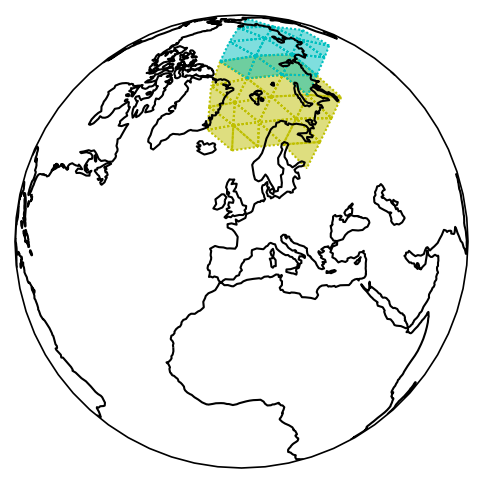

In [84]:
#del hpl
hpl = hello_plot1

if True:
    i=1
    i0=0
    i1=len(pp_covers[i])
    figax,sivs_cache,sivs_triang = hpl(
        spatial_index_values=pp_covers[i][i0:i1]
        ,set_coastlines=True
        ,plot_options=plot_options
#        ,plot_options=usr_plot_options
        ,set_global=True
        ,show_fig=False
        ,color='y'
        ,face_zs=['y']*len(pp_covers[i])
#        ,face_zs=numpy.arange(len(pp_covers[i][i0:i1]),dtype=numpy.float)/len(pp_covers[i])
#        ,face_zs=numpy.ones(shape=[len(pp_covers[i][i0:i1])],dtype=numpy.float)*0.9        
        ,face_edgecolors='k'
        ,face_alpha=0.5
#        ,face_cmap=cd_cmap
        ,face_cmap=None
        ,face_vmin=0.0
        ,face_vmax=1.0
        ,face_lw=0.0
        ,use_dash=[1]
        ,verbose=True
    )

    
if True:
    i=2
    i0=0
    i1=len(pp_covers[i])
    figax,sivs_cache,sivs_triang = hpl(
        spatial_index_values=pp_covers[i][i0:i1]
        ,figax=figax
        ,set_coastlines=True
        ,plot_options=plot_options
#        ,plot_options=usr_plot_options
        ,set_global=True
        ,show_fig=False
        ,color='c'
        ,face_zs=['c']*len(pp_covers[i])
#        ,face_zs=numpy.arange(len(pp_covers[i][i0:i1]),dtype=numpy.float)/len(pp_covers[i])
#        ,face_zs=numpy.ones(shape=[len(pp_covers[i][i0:i1])],dtype=numpy.float)*0.9        
        ,face_edgecolors='k'
        ,face_alpha=0.5
#        ,face_cmap=cd_cmap
        ,face_cmap=None
        ,face_vmin=0.0
        ,face_vmax=1.0
        ,face_lw=0.0
        ,use_dash=[1]
        ,verbose=True
    )
    
plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.
del figax

In [ ]:
sivs_triang.triangles

In [ ]:
len(pp_covers[i][0:1])

In [ ]:
t_ = tri(0,60,0.2,1)
t_

In [ ]:
p = patch(t_[0],t_[2],2,2)
p

In [ ]:
p_lla = list(map(to_lla,p))
p_lla

In [ ]:
p_llas = list(zip(*p_lla))
p_llas

In [ ]:
list(patch_geodetic(p))

In [ ]:
list(patch_periodic(p))

In [ ]:
list(map(to_lla,t_))

In [ ]:
delta_deg = 10
centers = [ rot(t_[0],t_[2],i) for i in range(0,361,delta_deg) ]

In [ ]:
llas = [ to_lla(c) for c in centers ]
llas

In [ ]:
lons,lats,alts = zip(*llas)

In [ ]:
n  = t_[2]
ps = [ patch(c,n,delta_deg,delta_deg) for c in centers ]
ps

In [ ]:
figax,sivs_cache,sivs_triang = hello_plot(
    set_coastlines=True
    ,plot_options=nearside_plot_options
    ,set_global=True
    ,show_fig=False)

figax.ax.plot(lons,lats,transform=ccrs.Geodetic())

for p in ps:
    pp = list(patch_periodic(p))
    pp_lons = pp[0]; pp_lats = pp[1]
    figax.ax.plot(pp_lons,pp_lats,transform=ccrs.Geodetic(),color='r')

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.
del figax